In [91]:
from utils.paths import *
from utils.raster_utils import *

import plotly.express as px

In [92]:
gps_coords = 46.04800, 7.64241
grid_size = 10
radius = 2000
path = '/Users/george-birchenough/sunmap_rasters/Switzerland_DEM_10m.tif'

array, observer_pixel, observer_height = get_square_masked_data(gps_coords, radius, grid_size, path)
array_cartesian = np.flip(array, axis=0)
elevation = 1
azimuth = 178

step_length = 5


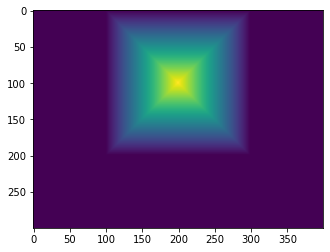

In [93]:
edge_length = int( 2 * radius / grid_size)
pyramid_length = int( edge_length / 2 )
array = np.zeros([pyramid_length,pyramid_length])
inset = int((edge_length - pyramid_length)/2)
for i in np.arange(pyramid_length):
    # i+=inset
    array[ i:pyramid_length-i,i:pyramid_length-i ] = i

array = np.pad(array, [(inset, 0), (inset, inset)], mode='constant', constant_values=0)
array = np.flip(array, axis=0)
plt.imshow(array)

In [94]:
nrows,ncols = array.shape
x_points = np.arange(ncols)
y_points = np.arange(nrows)
xy_points = (np.arange(nrows), np.arange(ncols))
# xy_points = ( np.arange(ncols), np.arange(nrows))

array_cartesian = np.flip(array, axis=0)
x_vector, y_vector, quadrant = get_azimuth_vector(azimuth)
x_vector*=step_length
y_vector*=step_length

df = pd.DataFrame()

fig = go.Figure()
fig2 = go.Figure()

n_starts = step_length

y_starts = n_starts * np.arange(nrows/n_starts)
for y_start in y_starts:
    # print('row ',y_start, ' of ', nrows)
    # We make interpolation points starting from first column of each row.
    x_start = 0
    x_sample = x_start
    y_sample = y_start
    inter_points = [[y_sample, x_sample]]

    while y_sample >= 0 and y_sample <= nrows - step_length and x_sample >= 0 and x_sample <= ncols - step_length:
        if quadrant == 1:
            y_sample = y_sample + y_vector
            x_sample = x_sample + x_vector
        if quadrant == 2:
            y_sample = y_sample + y_vector
            x_sample = x_sample + x_vector
        if quadrant == 3:
            y_sample = y_sample - y_vector
            x_sample = x_sample - x_vector
        if quadrant == 4:
            y_sample = y_sample + y_vector
            x_sample = x_sample - x_vector
        inter_points_ = [[y_sample, x_sample]]
        inter_points = np.concatenate([ inter_points , inter_points_ ])

    heights = interpn(xy_points, array_cartesian, inter_points, \
                method = 'linear', bounds_error = False, fill_value = 0 ) 
    distances =  np.arange(len(inter_points)) * step_length  # in metres
    df = pd.concat([df, get_shadows(heights, distances, inter_points, elevation)])

x_starts = n_starts * np.arange(ncols/n_starts)
for x_start in x_starts:
    # print('row ',y_start, ' of ', nrows)
    # We make interpolation points starting from first column of each row.
    y_start = 0
    x_sample = x_start
    y_sample = y_start
    inter_points = [[y_sample, x_sample]]

    while y_sample >= 0 and y_sample <= nrows - step_length and x_sample >= 0 and x_sample <= ncols - step_length:
        if quadrant == 1:
            y_sample = y_sample + y_vector
            x_sample = x_sample + x_vector
        if quadrant == 2:
            y_sample = y_sample + y_vector
            x_sample = x_sample + x_vector
        if quadrant == 3:
            y_sample = y_sample - y_vector
            x_sample = x_sample - x_vector
        if quadrant == 4:
            y_sample = y_sample + y_vector
            x_sample = x_sample - x_vector
        inter_points_ = [[y_sample, x_sample]]
        inter_points = np.concatenate([ inter_points , inter_points_ ])

    heights = interpn(xy_points, array_cartesian, inter_points, \
                method = 'linear', bounds_error = False, fill_value = 0 ) 
    distances =  np.arange(len(inter_points)) * step_length  # in metres
    df = pd.concat([df, get_shadows(heights, distances, inter_points, elevation)])


fig.add_trace( dict(
        type = 'contour',
        z=array_cartesian,
        x=x_points * grid_size,
        y=y_points * grid_size,
        contours = dict(
            start = array.min().round(1),
            end = array.max().round(1),
            size = 10,
            coloring = 'none',
            ),
        showlegend = False,
    ))

z=array_cartesian
x=x_points * grid_size
y=y_points * grid_size

fig.add_trace( dict(
        type = 'contour',
        z=z,
        x=x,
        y=y,
        contours = dict(
            start = z.min().round(100),
            end = z.max().round(100),
            size = 50,
            coloring = 'none',
            showlabels = True,
        ),
        showlegend = False,
    ))

fig.add_trace( dict(
        type = 'contour',
        z=z,
        x=x,
        y=y,
        contours = dict(
            start = z.min().round(10),
            end = z.max().round(10),
            size = 10,
            coloring = 'none',
            ),
        showlegend = False,
    ))
    
df.fillna(0,inplace=True)
df = df.loc[df.shadow == 1]

fig.add_trace( dict(
            type = 'scatter',
            x = df.x * grid_size,
            y = df.y * grid_size,
            mode = 'markers',
            marker = {'color':'black', 'size':5},
            opacity = 0.5
            )
    )

fig.update_layout(
    autosize = False,
    height = 800,
    width = 800,
    yaxis = dict(
            scaleanchor = 'x',
            scaleratio = 1
    ),
    xaxis = dict(
        range = [0, 2 * radius]
    )
)

fig.show()



In [95]:
type(array_cartesian)

numpy.ndarray

In [96]:
df.loc[df.y == 50]

Empty DataFrame
Columns: [d, z, x, y, max_el, shadow]
Index: []

In [97]:
df.loc[df.y == 100]

Empty DataFrame
Columns: [d, z, x, y, max_el, shadow]
Index: []

In [98]:
df

Empty DataFrame
Columns: [d, z, x, y, max_el, shadow]
Index: []

In [99]:
nrows,ncols = array.shape
x_points = np.arange(ncols)
y_points = np.arange(nrows)
xy_points = (y_points, x_points)

array_cartesian = np.flip(array, axis=0)
x_vector, y_vector, quadrant = get_azimuth_vector(azimuth)
x_vector*=step_length
y_vector*=step_length

df = pd.DataFrame()

fig = go.Figure()

# df = pd.DataFrame()

# for i, y_start in enumerate(y_points):

for y_start in 10 * np.arange(nrows/10):
    # print('row ',y_start, ' of ', nrows)
    # We make interpolation points starting from first column of each row.
    x_start = 0
    x_sample = x_start
    y_sample = y_start
    inter_points_ = inter_points = [[x_sample, y_sample]]
    while y_sample >= 0 and y_sample < nrows - step_length and x_sample >= 0 and x_sample < ncols - step_length:
        if quadrant == 1:
            y_sample = y_sample + y_vector
            x_sample = x_sample + x_vector
        if quadrant == 2:
            y_sample = y_sample + y_vector
            x_sample = x_sample + x_vector
        if quadrant == 3:
            y_sample = y_sample - y_vector
            x_sample = x_sample - x_vector
        if quadrant == 4:
            y_sample = y_sample - y_vector
            x_sample = x_sample - x_vector
        inter_points_ = [[x_sample, y_sample]]
        inter_points = np.concatenate([inter_points, inter_points_])
        print(inter_points)

    x = inter_points[:,0] * grid_size
    y = inter_points[:,1] * grid_size

    fig.add_trace( dict(
                type = 'scatter',
                x = x,
                y = y,
                mode = 'lines'
                
                )
    )
    

z = array
x = x_points * grid_size
y = y_points * grid_size



fig.add_trace( dict(
        type = 'contour',§
        z=z,
        x=x,
        y=y,
        # contours = dict(
        #     start = array.min().round(10),
        #     end = array.max().round(10),
        #     size = 10,
        #     coloring = 'none',
        #     ),
        showlegend = False,
    ))

fig.add_trace( dict(
            type = 'scatter',
            x = df.x * grid_size,
            y = df.y * grid_size,
            mode = 'markers'
            
            )
    )
 
fig.update_layout(
    autosize = False,
    height = 800,
    width = 800,
    yaxis = dict(
            scaleanchor = 'x',
            scaleratio = 1
    ),
    xaxis = dict(
        range = [0, 2 * radius]
    )
)

SyntaxError: invalid character in identifier (2795865205.py, line 63)

In [ ]:
# # x_s = df.x * 1000 / n_steps
# # y_s = (df.y * 1000 / n_steps)[::-1]
# # z_s = df.shadow

# z = array
# x = np.arange(0, 2*radius+grid_size, grid_size)
# y = x[::-1]

# slope_array = np.gradient(z)
# slope = ( ( np.array( slope_array[0]) **2 + np.array( slope_array[1]) **2 ) ** 0.5 ) / grid_size
# slope = np.arctan(slope) * 180 / np.pi

# fig = go.Figure()

# fig.add_trace( dict(
#         type = 'contour',
#         z=z,
#         x=x,
#         y=y,
#         contours = dict(
#             start = z.min().round(100),
#             end = z.max().round(100),
#             size = 50,
#             coloring = 'none',
#             showlabels = True,
#         ),
#         showlegend = False,
#     ))

# fig.add_trace( dict(
#         type = 'contour',
#         z=z,
#         x=x,
#         y=y,
#         contours = dict(
#             start = z.min().round(10),
#             end = z.max().round(10),
#             size = 10,
#             coloring = 'none',
#             ),
#         showlegend = False,
#     ))
    
# fig.update_layout(
#     autosize = False,
#     height = 800,
#     width = 800,
#     yaxis = dict(
#             scaleanchor = 'x',
#             scaleratio = 1
#     ),
#     xaxis = dict(
#         range = [0, 2*radius]
#     )
# )

# # fig.add_trace( dict(
# #         type = 'heatmap',
# #         z = z_s,
# #         x= x_s,
# #         y= y_s,
# #         opacity = 0.5
# #         # contours = dict(
# #         #     start = array.min().round(10),
# #         #     end = array.max().round(10),
# #         #     size = 10,
# #         #     coloring = 'none',
# #         #     )
# #     ))

# def make_colormap(slope):
#     range = slope.max() - slope.min()

#     discrete_angles = np.array( [slope.min(), 30, 35, 40, 45, 50, 55, slope.max()] )

#     norm_intervals = ( discrete_angles - slope.min() ) / range

#     map = [(slope.min(),'white'), (30,'white'), (35,'#F0E54D'), (40,'#E4773B'), (45, '#CC2D5C'), (50, '#BF8CB8'), (55, '#524691'), (60, '#8BC4BF'),  (90, '#1D1D1B')]

#     mapless = []
#     for i in np.arange(len(map)):
#         if map[i][0] < slope.max():
#             mapless.append([ map[i][0], map[i][1] ] )
#             largest_index = i

#     mapless.append( [slope.max(), map[largest_index][1]] )


#     dcolors = []
#     for i in np.arange(len(mapless)):
#         try:
#             dcolors.append( [ (mapless[i][0]-slope.min())/range  , mapless[i][1] ] )
#             dcolors.append( [ (mapless[i][0]-slope.min())/range  , mapless[i+1][1] ] )
#         # print( i[0],i[1] )
#         except:
#             pass
#     return dcolors

# # dcolors = make_colormap(slope)
# # fig.add_trace( dict(
# #         type = 'heatmap',
# #         z = slope,
# #         x=x,
# #         y=y,
# #         colorscale = dcolors,
# #         opacity = 0.5
# #         # contours = dict(
# #         #     start = array.min().round(10),
# #         #     end = array.max().round(10),
# #         #     size = 10,
# #         #     coloring = 'none',
# #         #     )
# #     ))

# fig.show()